In [107]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [108]:
#READING
train=pd.read_csv('D:/R/upvotes prediction/train.csv')
test=pd.read_csv('D:/R/upvotes prediction/test.csv')

In [109]:
# BINDING
master=pd.concat([train,test],ignore_index=True)
print(train.shape,test.shape,master.shape)
master.head()

(330045, 7) (141448, 6) (471493, 7)


,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [110]:
### Chck Dtypes
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471493 entries, 0 to 471492
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          471493 non-null  int64  
 1   Tag         471493 non-null  object 
 2   Reputation  471493 non-null  float64
 3   Answers     471493 non-null  float64
 4   Username    471493 non-null  int64  
 5   Views       471493 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.2+ MB


In [111]:
# Check column names
print(master.columns)

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')


In [112]:
# check na
master.isnull().sum()/len(master)*100

ID             0.000000
Tag            0.000000
Reputation     0.000000
Answers        0.000000
Username       0.000000
Views          0.000000
Upvotes       30.000021
dtype: float64

In [113]:
# CHECK UNIQUE VALUES

master.apply(lambda x : len(x.unique()))

ID            471493
Tag               10
Reputation     17414
Answers           65
Username      175739
Views          97801
Upvotes         7240
dtype: int64

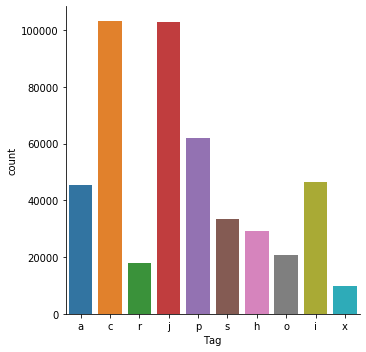

In [114]:
# Check Tag
sns.catplot(x='Tag',kind='count',data=master)
a={'a':0,'c':1,'r':2,'j':3,'p':4,'s':5,'h':6,'o':7,'i':8,'x':9}
master.Tag=master.Tag.map(a)
master.Tag=master.Tag.astype(int)

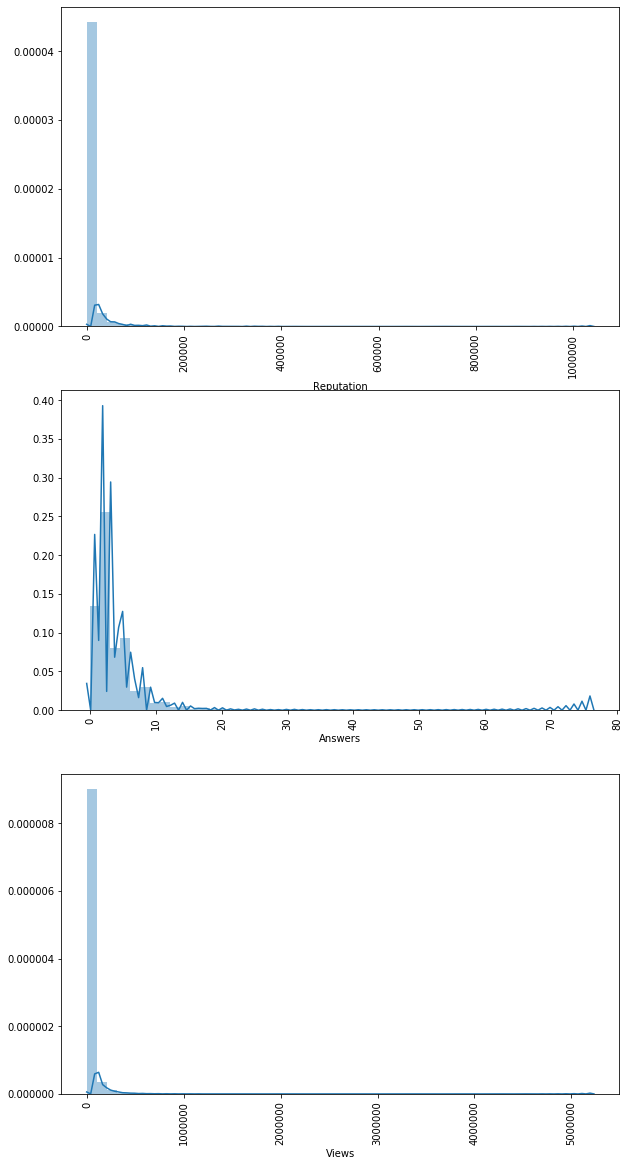

In [115]:
# Check Numerical Variables

num=['Reputation','Answers','Views','Upvotes']
final=master[num]

#Numerical
fig, ax=plt.subplots(3,figsize=(10,20))
for variable,subplot in zip(num,ax.flatten()):
    sns.distplot(final[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

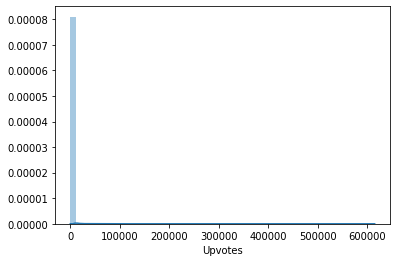

In [116]:
######skewness check####
#CHECK TARGET VARIABLE BEFORE TRANSFORMATION
sns.distplot(master.Upvotes)

In [117]:
#DROP OUT COLOUMNS

master=master.drop(['Username'],axis=1)
master.head()

,ID,Tag,Reputation,Answers,Views,Upvotes
0,52664,0,3942.0,2.0,7855.0,42.0
1,327662,0,26046.0,12.0,55801.0,1175.0
2,468453,1,1358.0,4.0,8067.0,60.0
3,96996,0,264.0,3.0,27064.0,9.0
4,131465,1,4271.0,4.0,13986.0,83.0


In [118]:
#FEATURE ENGINEERIN#
master['Watched']=master.Answers * master.Views
master['Tag']=master['Tag'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471493 entries, 0 to 471492
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          471493 non-null  int64  
 1   Tag         471493 non-null  object 
 2   Reputation  471493 non-null  float64
 3   Answers     471493 non-null  float64
 4   Views       471493 non-null  float64
 5   Upvotes     330045 non-null  float64
 6   Watched     471493 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 25.2+ MB


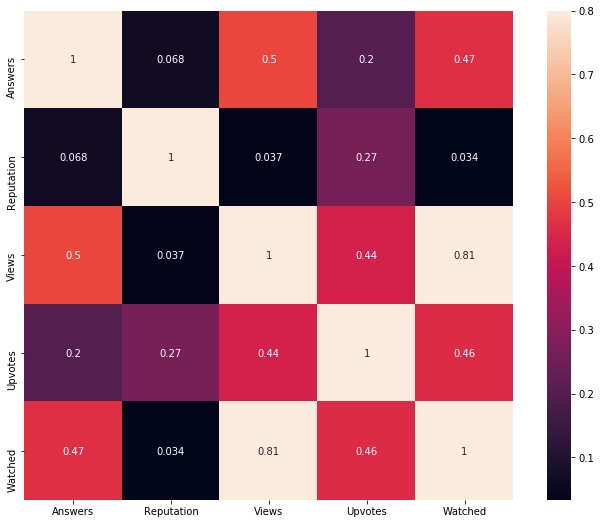

In [119]:
master.info()
contvars=master[['Answers','Reputation','Views','Upvotes','Watched']]
#####CORRELATION MATRIX######
#correlation matrix
corrmat = contvars.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,annot = True,square=True);

In [120]:
######SKEWNESS#####
from scipy import stats
from scipy.stats import norm, skew

ct={'Answers','Reputation','Views','Upvotes','Watched'}
numeric_feats = ct
#Check the skew of all numerical features
skewed_feats = master[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
Upvotes,74.249352
Watched,58.097271
Views,14.123456
Reputation,11.261825
Answers,3.385518


In [121]:
#########SKEWNESS TREATMENT###############
############TRANSFORMATION USING BOXCOX########

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for i in skewed_features:
    #master[feat] += 1
    master[i] = boxcox1p(master[i], lam)

There are 5 skewed numerical features to Box Cox transform


In [122]:
####LABEL ENCODING####
labelencoder_X = LabelEncoder()
master['Tag'] = labelencoder_X.fit_transform(master'Tag'])

SyntaxError: invalid syntax (<ipython-input-122-d6f62b878de4>, line 3)

In [ ]:
sns.distplot(master.Upvotes)

In [ ]:
##########MODEL BUILDING###########

master= pd.get_dummies(master, columns=['Tag'])
master.head()

X = master[master['Upvotes'].isnull()!=True].drop(['ID','Upvotes'], axis=1)
y = master[master['Upvotes'].isnull()!=True]['Upvotes']

X_test = master[master['Upvotes'].isnull()==True].drop(['ID','Upvotes'], axis=1)

X.shape, y.shape, X_test.shape



In [ ]:
########SPLITTING#####
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


In [ ]:
###SCALING##

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)


In [123]:
##########RIDGE REGRESSION##########

list1=[0.0018,0.002,0.005,0.08,0.09,0.1,0.5]
list2=[]
for i in list1:
    ridge_reg = Ridge(alpha=i,normalize=True)
    ridge_reg.fit(x_train,y_train)
    y_pred_r=ridge_reg.predict(x_val)
    r2score_r= r2_score(y_val,y_pred_r)
    list2.append(r2score_r)

ridge_rscore_df=pd.DataFrame({"ALPHA":list1,"R2SCORE":list2})
ridge_rscore_df 

,ALPHA,R2SCORE
0,0.0018,0.779909
1,0.0020,0.779860
2,0.0050,0.779095
3,0.0800,0.773128
4,0.0900,0.772419
5,0.1000,0.771673
6,0.5000,0.725248


In [124]:
#####LINEAR REGRESSION###
logmodel = LinearRegression()
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_val)

model_score = logmodel.score(x_train,y_train)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ',model_score)
# Accuracy Score
acc_log = round(logmodel.score(x_train, y_train) * 100, 2)
print('Acc: ',acc_log)

R2 sq:  0.7783389751216909
Acc:  77.83


In [101]:
### GBM###
from sklearn import ensemble
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)

model.fit(x_train, y_train)


from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(x_train,y_train)

# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ',model_score)
y_predicted = model.predict(x_val)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_val, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_val, y_predicted))
# Accuracy Score
acc_log = round(model.score(x_train, y_train) * 100, 2)
print('Acc: ',acc_log)

R2 sq:  0.8898493241224454
Mean squared error: 1.42
Test Variance score: 0.89
Acc:  88.98


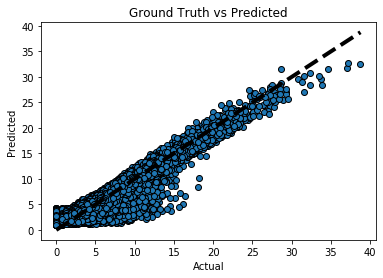

In [102]:
fig, ax = plt.subplots()
ax.scatter(y_val, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [103]:
prediction = model.predict(X_test)
submission = pd.DataFrame()
submission['ID'] = master[master['Upvotes'].isnull()==True]['ID']
submission['Upvotes'] = prediction
submission.to_csv('upvs.csv', index=False, header=True)
submission.shape

(141448, 2)